# Behavioral Index to Prove Novelty
1. Template Retrieval

In [2]:
from mylib.statistic_test import *

code_id = '0869 - Detailed Behavioral Analysis'
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)

StatePalette = ['#b3d99b', '#d1c8e4', '#a3c1e0', '#ffcc99']
pass

        E:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis is already existed!


# Template Speed

        E:\Data\FinalResults\Dsp\0869 - Detailed Behavioral Analysis\template is already existed!


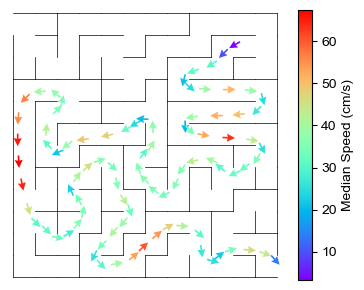

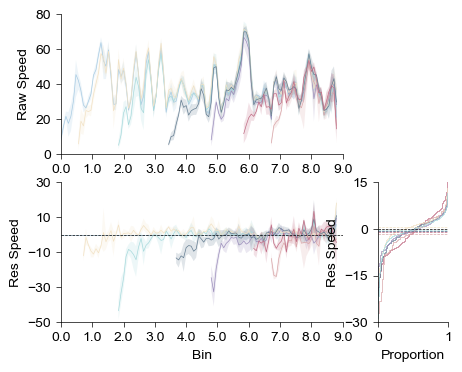

R1: Fr. 2.24  TtestResult(statistic=-1.3354506707981049, pvalue=0.09132324771107546, df=331)
R2: Fr. 5.84  TtestResult(statistic=-1.4195050599775996, pvalue=0.0789133225638575, df=150)
R3: Fr. 7.76  TtestResult(statistic=-1.6491324706724395, pvalue=0.05246337712623422, df=54)
R4: Fr. 0.72  TtestResult(statistic=3.1794746199956547, pvalue=0.999205734220596, df=406)
R5: Fr. 3.84  TtestResult(statistic=-1.6311834985959228, pvalue=0.0520553381411126, df=250)
R6: Fr. 6.16  TtestResult(statistic=-1.5086341574630278, pvalue=0.06687325021801485, df=134)


In [37]:
import scipy.stats

dir_template = join(loc, 'template')
mkdir(dir_template)

def get_median_of_angle(angles):
    """
    Calculate the median of angles in radians.
    """
    # Get the most common angle
    x = np.cos(angles)
    y = np.sin(angles)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    mean_angle = np.arctan2(y_mean, x_mean)
    
    # Convert angle to be mean_centered
    angles -= mean_angle
    angles[angles < -np.pi] += 2 * np.pi
    angles[angles > np.pi] -= 2 * np.pi
    median_angle = np.median(angles)
    
    # Convert back to original angle
    median_angle += mean_angle
    if median_angle < -np.pi:
        median_angle += 2 * np.pi
    elif median_angle > np.pi:
        median_angle -= 2 * np.pi

    return median_angle

def get_mean_of_angle(angles):
    """
    Calculate the median of angles in radians.
    """
    # Get the most common angle
    x = np.cos(angles)
    y = np.sin(angles)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    mean_angle = np.arctan2(y_mean, x_mean)
    
    return mean_angle

def generate_template_movement(mouse: int):
    """
    Generate a movement template for a specific mouse at each spatial bin.
    The template is a 4-dimensional vector containing the average position (x, y),
    direction, and speed.
    """
    file_idx = np.where(f2['MiceID'] == mouse)[0]

    templates = np.zeros((144, 4, 7)) # 144 bin, 4-dim vector: position x and y, direction, speed
    behav_vec = [[] for i in range(7)]
    behav_nodes_all = [[] for i in range(7)]
    for i in tqdm(range(7)):
        with open(f2['Trace File'][file_idx[i]], 'rb') as f:
            trace = pickle.load(f)
            
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)        
        behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
        
        for j in range(len(beg)):
            if (trace['is_perfect'][j] == 1 and routes[j] == 0) or (trace['is_perfect'][j] == 1 and routes[j] != 0 and i >= 3):
                dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
                dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
                dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
                v = dl / dt
                # Moving Direction
                a = np.arctan2(dp[:, 1], dp[:, 0])
                
                behav_vec[routes[j]].append(np.vstack([
                    trace['correct_pos'][beg[j]:end[j]-1, :].T/10,
                    a,
                    v
                ]))
                behav_nodes_all[routes[j]].append(behav_nodes[beg[j]:end[j]-1])
                
    for i in range(7):         
        behav_vec[i] = np.concatenate(behav_vec[i], axis=1)
        behav_nodes_all[i] = np.concatenate(behav_nodes_all[i])
    
    for r in range(7):
        for b in range(144):
            idx = np.where(behav_nodes_all[r] == b+1)[0]
            if len(idx) > 0:
                templates[b, :, r] = np.median(behav_vec[r][:, idx], axis=1)
                templates[b, 2, r] = get_median_of_angle(behav_vec[r][2, idx])
            else:
                templates[b, :, r] = np.nan
    
    with open(join(dir_template, f'{mouse}.pkl'), 'wb') as f:
        pickle.dump(templates, f)
        
    return templates
"""
generate_template_movement(10212)
generate_template_movement(10224)
generate_template_movement(10227)
generate_template_movement(10232)
"""
def visualize_template(mouse: int, route: int = 0):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
    
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, maze_type=1, color='k', linewidth=0.5)
    qver = ax.quiver(
        template[:, 0, route]/2-0.5, template[:, 1, route]/2-0.5,
        5*np.cos(template[:, 2, route]), -5*np.sin(template[:, 2, route]),
        template[:, 3, route], # color by direction
        cmap='rainbow',
        headwidth=5,
        width=0.006
    )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.colorbar(qver, ax=ax, label='Median Speed (cm/s)')
    plt.tight_layout()
    plt.savefig(join(loc, f'Behav Template [{mouse}].png'), dpi=600)
    plt.savefig(join(loc, f'Behav Template [{mouse}].svg'), dpi=600)
    plt.show()
"""
visualize_template(10212)
visualize_template(10224)
visualize_template(10227)
visualize_template(10232)
"""
visualize_template(10232, route=0)
if exists(join(figdata, f'{code_id} [Examine Template].pkl')) == False:
    ExTempData = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Raw Speed': [],
        'Res Speed': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
            
        for r in range(0, 7):
            raw_speed = template[CP_DSP[r]-1, 3, r]
            res_speed = template[CP_DSP[r]-1, 3, r] - template[CP_DSP[r]-1, 3, 0]
            
            ExTempData['MiceID'].append(np.repeat(mouse, len(raw_speed)))
            ExTempData['Route'].append(np.repeat(r, len(raw_speed)))
            ExTempData['Bin'].append(np.arange(111)[-len(raw_speed):])
            ExTempData['Raw Speed'].append(raw_speed)
            ExTempData['Res Speed'].append(res_speed)
            
    for k in ExTempData.keys():
        ExTempData[k] = np.concatenate(ExTempData[k])
    
    with open(join(figdata, f'{code_id} [Examine Template].pkl'), 'wb') as f:
        pickle.dump(ExTempData, f)
        
    ExTempD = pd.DataFrame(ExTempData)
    ExTempD.to_excel(join(figdata, f'{code_id} [Examine Template].xlsx'), index=False)
    print(len(ExTempD))
else:
    with open(join(figdata, f'{code_id} [Examine Template].pkl'), 'rb') as f:
        ExTempData = pickle.load(f)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), gridspec_kw={'width_ratios':[4,1]})
ax0 = Clear_Axes(axes[0, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempData,
    x='Bin',
    y='Raw Speed',
    hue='Route',
    palette=DSPPalette,
    ax=ax0,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax0.set_ylim(0, 80)
ax0.set_yticks(np.linspace(0, 80, 5))
ax0.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax0.set_xlim(0, 112.5)

ax1 = Clear_Axes(axes[1, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempData,
    x='Bin',
    y='Res Speed',
    hue='Route',
    palette=DSPPalette,
    ax=ax1,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax1.set_ylim(-50, 30)
ax1.set_yticks(np.linspace(-50, 30, 5))
ax1.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax1.set_xlim(0, 112.5)

Clear_Axes(axes[0, 1])

init_pos = np.array([0, 28, 73, 97, 9, 48, 77])

SubIdx = np.where(
    ((ExTempData['Route'] == 1) & (ExTempData['Bin'] >= init_pos[1])) |
    ((ExTempData['Route'] == 2) & (ExTempData['Bin'] >= init_pos[2])) |
    ((ExTempData['Route'] == 3) & (ExTempData['Bin'] >= init_pos[3])) |
    ((ExTempData['Route'] == 4) & (ExTempData['Bin'] >= init_pos[4])) |
    ((ExTempData['Route'] == 5) & (ExTempData['Bin'] >= init_pos[5])) |
    ((ExTempData['Route'] == 6) & (ExTempData['Bin'] >= init_pos[6]))
)[0]
SubData = SubDict(ExTempData, ExTempData.keys(), SubIdx)
ax2 = Clear_Axes(axes[1, 1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.ecdfplot(
    data=SubData,
    y='Res Speed',
    hue='Route',
    palette=DSPPalette[1:],
    ax=ax2,
    linewidth=0.5,
    #bins=40,
    #binrange=(-50, 30),
    #line_kws={'linewidth': 0.5},
    #stat='density', 
    #element="step",
    legend=False,
)
ax2.set_ylim(-30, 15)
ax2.set_yticks(np.linspace(-30, 15, 4))
#ax2.set_xlim(0, 0.06)
#ax2.set_xticks(np.linspace(0, 0.06, 4))
ax2.set_xlim(0, 1)
ax2.set_xticks((0, 1))
for r in range(1, 7):
    res_data = SubData['Res Speed'][(SubData['Route'] == r)&(np.isnan(SubData['Res Speed'])==False)]
    bar = np.mean(res_data)
    ax2.axhline(bar, color=DSPPalette[r], linewidth=0.5, linestyle='--')
ax2.axhline(0, color='k', linewidth=0.5, linestyle='--')
plt.savefig(join(loc, f'Examine Template.png'), dpi=600)
plt.savefig(join(loc, f'Examine Template.svg'), dpi=600)
plt.show()

init_m = init_pos/12.5
for r in range(1, 7):
    idx = np.where((ExTempData['Route'] == r)&(np.isnan(ExTempData['Res Speed']) == False)&(ExTempData['Bin']>=init_pos[r]))[0]
    print(f"R{r}: Fr. {init_m[r]:.2f}  {ttest_1samp(ExTempData['Res Speed'][idx], 0, alternative='less')}")

# Template Direction

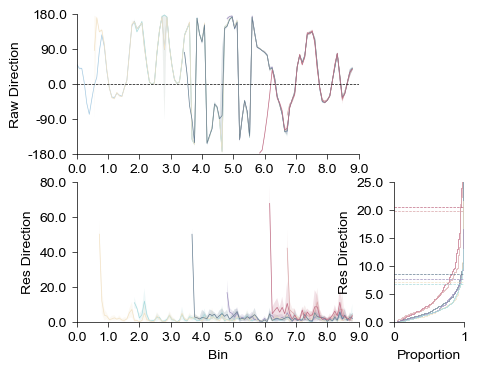

In [8]:
if exists(join(figdata, f'{code_id} [Examine Template Direction].pkl')) == False:
    ExTempDirData = {
        'MiceID': [],
        'Route': [],
        'Bin': [],
        'Raw Direction': [],
        'Res Direction': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
            
        for r in range(0, 7):
            raw_direction = template[CP_DSP[r]-1, 2, r]
            res_direction = template[CP_DSP[r]-1, 2, r] - template[CP_DSP[r]-1, 2, 0]
            res_direction[res_direction > np.pi] = 2*np.pi - res_direction[res_direction > np.pi]
            res_direction[res_direction < -np.pi] = -2*np.pi - res_direction[res_direction < -np.pi]
            res_direction = np.abs(res_direction)

            ExTempDirData['MiceID'].append(np.repeat(mouse, len(raw_direction)))
            ExTempDirData['Route'].append(np.repeat(r, len(raw_direction)))
            ExTempDirData['Bin'].append(np.arange(111)[-len(raw_direction):])
            ExTempDirData['Raw Direction'].append(raw_direction)
            ExTempDirData['Res Direction'].append(res_direction)

    for k in ExTempDirData.keys():
        ExTempDirData[k] = np.concatenate(ExTempDirData[k])

    with open(join(figdata, f'{code_id} [Examine Template Direction].pkl'), 'wb') as f:
        pickle.dump(ExTempDirData, f)

    ExTempDirD = pd.DataFrame(ExTempDirData)
    ExTempDirD.to_excel(join(figdata, f'{code_id} [Examine Template Direction].xlsx'), index=False)
    print(len(ExTempDirD))
else:
    with open(join(figdata, f'{code_id} [Examine Template Direction].pkl'), 'rb') as f:
        ExTempDirData = pickle.load(f)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), gridspec_kw={'width_ratios':[4,1]})
ax0 = Clear_Axes(axes[0, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempDirData,
    x='Bin',
    y='Raw Direction',
    hue='Route',
    palette=DSPPalette,
    ax=ax0,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax0.set_ylim(-np.pi, np.pi)
ax0.set_yticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax0.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax0.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax0.set_xlim(0, 112.5)

ax1 = Clear_Axes(axes[1, 0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    data=ExTempDirData,
    x='Bin',
    y='Res Direction',
    hue='Route',
    palette=DSPPalette,
    ax=ax1,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    legend=False
)
ax1.set_ylim(0, np.pi*4/9)
ax1.set_yticks(np.linspace(0, np.pi*4/9, 5), np.linspace(0, 80, 5))
ax1.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax1.set_xlim(0, 112.5)

Clear_Axes(axes[0, 1])

ax2 = Clear_Axes(axes[1, 1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(ExTempDirData, ExTempDirData.keys(), np.where(ExTempDirData['Route'] != 0)[0])
sns.ecdfplot(
    data=SubData,
    y='Res Direction',
    hue='Route',
    palette=DSPPalette[1:],
    ax=ax2,
    linewidth=0.5,
    #line_kws={'linewidth': 0.5},
    legend=False
)
for r in range(1, 7):
    res_dir = SubData['Res Direction'][(SubData['Route'] == r)&(np.isnan(SubData['Res Direction']) == False)]
    bar = np.percentile(res_dir, 95)
    ax2.axhline(bar, color=DSPPalette[r], linewidth=0.5, linestyle='--')
ax2.set_ylim(0, np.pi*1/9*1.25)
ax2.set_yticks(np.linspace(0, np.pi*1/9*1.25, 6), np.linspace(0, 25, 6))
ax2.set_xlim(0, 1)
plt.savefig(join(loc, f'Examine Template Direction.png'), dpi=600)

plt.savefig(join(loc, f'Examine Template Direction.svg'), dpi=600)
plt.show()

# Consistency of Behavioral Template

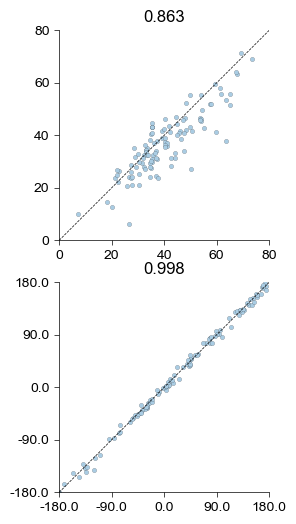

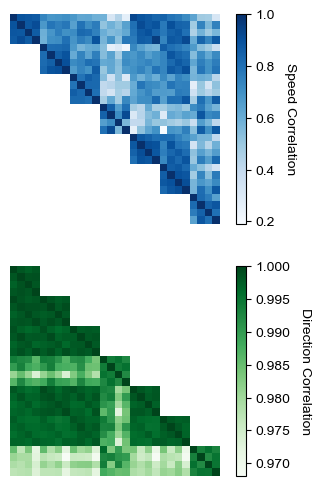

In [49]:
with open(join(dir_template, '10232.pkl'), 'rb') as handle:
    template32 = pickle.load(handle)
    
with open(join(dir_template, '10227.pkl'), 'rb') as handle:
    template27 = pickle.load(handle)

dtheta = template32[CP_DSP[0][:-1]-1, 2, 0] - template27[CP_DSP[0][:-1]-1, 2, 0]
x = cp.deepcopy(template32[CP_DSP[0][:-1]-1, 2, 0])
y = cp.deepcopy(template27[CP_DSP[0][:-1]-1, 2, 0])
x[dtheta > np.pi] -= 2*np.pi
x[dtheta < - np.pi] += 2*np.pi

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax0.scatter(
    template32[CP_DSP[0]-1, 3, 0],
    template27[CP_DSP[0]-1, 3, 0],
    c=DSPPalette[0],
    s=10,
    edgecolors='k',
    linewidths=0.1,
)
ax0.axis([0, 80, 0, 80])
ax0.set_aspect('equal')
ax0.set_xticks(np.linspace(0, 80, 5))
ax0.set_yticks(np.linspace(0, 80, 5))
ax0.plot([0, 80], [0, 80], color='k', linewidth=0.5, linestyle='--')
ax0.set_title(f"{pearsonr(template32[CP_DSP[0]-1, 3, 0], template27[CP_DSP[0]-1, 3, 0])[0]:.3f}")

ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax1.scatter(
    x, y,
    c=DSPPalette[0],
    s=10,
    edgecolors='k',
    linewidths=0.1,
)
ax1.axis([-np.pi, np.pi, -np.pi, np.pi])
ax1.set_aspect('equal')
ax1.set_xticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax1.set_yticks(np.linspace(-np.pi, np.pi, 5), np.linspace(-180, 180, 5))
ax1.plot([-np.pi, np.pi], [-np.pi, np.pi], color='k', linewidth=0.5, linestyle='--')
ax1.set_title(f"{pearsonr(x, y)[0]:.3f}")
plt.savefig(join(loc, f"Template Consistency [32 vs. 27 Example].png"))
plt.savefig(join(loc, f"Template Consistency [32 vs. 27 Example].svg"))
plt.show()

if exists(join(figdata, f"{code_id}  [Template Consistency].pkl")) == False:
    SpeedCorrMat = np.zeros((4*7, 4*7), np.float64) * np.nan
    DirCorrMat = np.zeros((4*7, 4*7), np.float64) * np.nan
    
    template_set = []
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
        
        template_set.append(template)
        
    for ri in range(7):
        for rj in range(ri, 7):
            intersected_bins = np.intersect1d(CP_DSP[ri], CP_DSP[rj])
            res_speed = np.zeros((4, 4), np.float64) * np.nan
            res_angle = np.zeros((4, 4), np.float64) * np.nan
            for i in range(4):
                for j in range(4):
                    # Remove the last bin as sometimes there're no data for that bin
                    # such that the correlation is nan.
                    res_speed[i, j] = np.corrcoef(
                        template_set[i][intersected_bins[:-1]-1, 3, ri],
                        template_set[j][intersected_bins[:-1]-1, 3, rj]
                    )[0, 1]
                    
                    dtheta = template_set[i][intersected_bins[:-1]-1, 2, ri] - template_set[j][intersected_bins[:-1]-1, 2, rj]
                    x = cp.deepcopy(template_set[i][intersected_bins[:-1]-1, 2, ri])
                    y = cp.deepcopy(template_set[j][intersected_bins[:-1]-1, 2, rj])
                    x[dtheta > np.pi] -= 2*np.pi
                    x[dtheta < - np.pi] += 2*np.pi
                    
                    res_angle[i, j] = np.corrcoef(x, y)[0, 1]
                    SpeedCorrMat[np.ix_(range(ri*4, (ri+1)*4), range(rj*4, (rj+1)*4))] = res_speed
            DirCorrMat[np.ix_(range(rj*4, (rj+1)*4), range(ri*4, (ri+1)*4))] = res_angle
            
    with open(join(figdata, f"{code_id} [Template Consistency].pkl"), 'wb') as f:
        pickle.dump({
            'Speed': SpeedCorrMat,
            'Angle': DirCorrMat
        }, f)
else:
    with open(join(figdata, f"{code_id} [Template Consistency].pkl"), 'rb') as f:
        TemplateConsistency = pickle.load(f)
        SpeedCorrMat = TemplateConsistency['Speed']
        DirCorrMat = TemplateConsistency['Angle']
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 6))
ax0 = Clear_Axes(axes[0])
im = ax0.imshow(SpeedCorrMat, cmap='Blues', vmax=1)
ax0.set_aspect('equal')
# Add colorbar
cbar = plt.colorbar(im, ax=ax0)
cbar.set_label('Speed Correlation', rotation=270, labelpad=15)

ax1 = Clear_Axes(axes[1])
im = ax1.imshow(DirCorrMat, cmap='Greens', vmax=1)
ax1.set_aspect('equal')
# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Direction Correlation', rotation=270, labelpad=15)
plt.savefig(join(loc, f"Template Consistency.png"), dpi=600)
plt.savefig(join(loc, f"Template Consistency.svg"), dpi=600)
plt.show()

# Examine Behavioral Retrieval

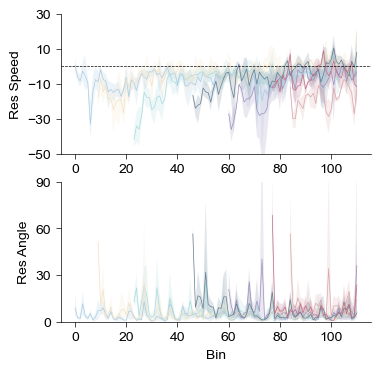

In [ ]:
def behavioral_template_retrieval(mouse: int, session: int):
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
        
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    
    behav_nodes_traj = []
    behav_lap_traj = []
    behav_routes_traj = []
    behav_session_traj = []
    behav_params_traj = []
    behav_params_templ_traj = []
    behav_dt_traj = []
    behav_t_traj = []


    for j in range(len(beg)):
        dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
        dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
        dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
        v = dl/dt
        # Moving Direction
        a = np.arctan2(dp[:, 1], dp[:, 0])
        
        params = np.vstack([
            trace['correct_pos'][beg[j]:end[j]-1, :].T/10,
            a,
            v
        ])
        params_templ = template[behav_nodes[beg[j]:end[j]-1]-1, :, routes[j]].T
        
        behav_nodes_traj.append(behav_nodes[beg[j]:end[j]-1])
        behav_lap_traj.append(np.repeat(j, len(params[0])))
        behav_routes_traj.append(np.repeat(routes[j], len(params[0])))
        behav_session_traj.append(np.repeat(session, len(params[0])))
        behav_params_traj.append(params)
        behav_params_templ_traj.append(params_templ)
        behav_dt_traj.append(dt)
        behav_t_traj.append(trace['correct_time'][beg[j]:end[j]-1] - trace['correct_time'][beg[j]])
        
    behav_nodes_traj = np.concatenate(behav_nodes_traj)
    behav_lap_traj = np.concatenate(behav_lap_traj)
    behav_routes_traj = np.concatenate(behav_routes_traj)
    behav_session_traj = np.concatenate(behav_session_traj)
    behav_params_traj = np.concatenate(behav_params_traj, axis=1)
    behav_params_templ_traj = np.concatenate(behav_params_templ_traj, axis=1)
    behav_dt_traj = np.concatenate(behav_dt_traj)
    behav_t_traj = np.concatenate(behav_t_traj)
    
    
    return (
        behav_nodes_traj,
        behav_lap_traj,
        behav_routes_traj,
        behav_session_traj,
        behav_params_traj,
        behav_params_templ_traj,
        behav_dt_traj,
        behav_t_traj
   )
    
def get_nontemplate_profile(mouse: int, session: int) -> np.ndarray:
    (
        behav_nodes_traj,
        behav_lap_traj,
        behav_routes_traj,
        behav_session_traj,
        behav_params_traj,
        behav_params_templ_traj,
        behav_dt_traj,
        behav_t_traj
   ) = behavioral_template_retrieval(mouse, session)

    templates = np.zeros((144, 4, 7)) # 144 bin, 4-dim vector: position x and y, direction, speed
    for r in range(7):
        for b in CP_DSP[r]:
            idx = np.where((behav_nodes_traj == b) & (behav_routes_traj == r))[0]
            if len(idx) > 0:
                templates[b-1, :, r] = np.median(behav_params_traj[:, idx], axis=1)
                templates[b-1, 2, r] = get_median_of_angle(behav_params_traj[2, idx])
            else:
                templates[b-1, :, r] = np.nan
                
    return templates
"""    
if exists(join(figdata, f'{code_id} [Behavioral Template Retrieval].pkl')) == False:
    BehavTemplRetrievData = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'Res Speed': [],
        'Res Angle': [],
        'Bin': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
            template = pickle.load(f)
            
        for session in tqdm(range(7)): 
            nontemplate_prof = get_nontemplate_profile(mouse, session)
            for r in range(7):
                res_speed = nontemplate_prof[CP_DSP[r]-1, 3, r] - template[CP_DSP[r]-1, 3, 0]
                res_angle = nontemplate_prof[CP_DSP[r]-1, 2, r] - template[CP_DSP[r]-1, 2, 0]
                res_angle[res_angle > np.pi] = 2*np.pi - res_angle[res_angle > np.pi]
                res_angle[res_angle < -np.pi] = -2*np.pi - res_angle[res_angle < -np.pi]
                res_angle = np.abs(res_angle)
                res_angle = np.rad2deg(res_angle)
                
                BehavTemplRetrievData['MiceID'].append(np.repeat(mouse, len(res_speed)))
                BehavTemplRetrievData['Session'].append(np.repeat(session, len(res_speed))) 
                BehavTemplRetrievData['Route'].append(np.repeat(r, len(res_speed)))
                BehavTemplRetrievData['Res Speed'].append(res_speed)
                BehavTemplRetrievData['Res Angle'].append(res_angle)
                BehavTemplRetrievData['Bin'].append(np.arange(111)[-len(res_speed):])
    
    for k in BehavTemplRetrievData.keys():
        BehavTemplRetrievData[k] = np.concatenate(BehavTemplRetrievData[k])
        
    with open(join(figdata, f'{code_id} [Behavioral Template Retrieval].pkl'), 'wb') as f:
        pickle.dump(BehavTemplRetrievData, f)
        
    BehavTemplRetrievD = pd.DataFrame(BehavTemplRetrievData)
    BehavTemplRetrievD.to_excel(join(figdata, f'{code_id} [Behavioral Template Retrieval].xlsx'), index=False)
    print(len(BehavTemplRetrievD))
else:
    with open(join(figdata, f'{code_id} [Behavioral Template Retrieval].pkl'), 'rb') as f:
        BehavTemplRetrievData = pickle.load(f)

D = GetDMatrices(1, 12)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4))
ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(BehavTemplRetrievData, BehavTemplRetrievData.keys(), np.where(BehavTemplRetrievData['Session'] == 0)[0])
sns.lineplot(
    x='Bin',
    y='Res Speed',
    hue='Route',
    data=SubData,
    ax=ax0,
    linewidth=0.5,
    palette=DSPPalette,
    err_kws={'edgecolor': None},
    legend=False
)
ax0.set_ylim(-50, 30)
ax0.set_yticks(np.linspace(-50, 30, 5))
ax0.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax0.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax0.set_xlim(0, 112.5)

ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Bin',
    y='Res Angle',
    hue='Route',
    data=SubData,
    ax=ax1,
    linewidth=0.5,
    palette=DSPPalette,
    err_kws={'edgecolor': None},
    legend=False,
)
ax1.set_ylim(0, 90)
ax1.set_yticks(np.linspace(0, 90, 4))
ax1.set_xticks(np.linspace(0, 112.5, 10), np.linspace(0, 9, 10))
ax1.set_xlim(0, 112.5)
plt.savefig(join(loc, f'Behavioral Template Retrieval [S0].png'), dpi=600)
plt.savefig(join(loc, f'Behavioral Template Retrieval [S0].svg'), dpi=600)
plt.show()
"""

In [ ]:
def detect_violate_template_event(mouse: int, session: int, is_draw: bool = True):
    print(f"{mouse} - S{session+1}")
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    with open(f2['Trace File'][file_idx], 'rb') as f:
        trace = pickle.load(f)
        
    with open(join(dir_template, f"{mouse}.pkl"), 'rb') as f:
        template = pickle.load(f)
        
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)        
    behav_nodes = spike_nodes_transform(trace['correct_nodes'], 12)
    
    behav_distances = []
    behav_angles_templ = []
    behav_angles = []
    behav_speed = []
    behav_speed_templ = []
    behav_nodes_subset = []
    behav_routes = []
    behav_dt = []
    
    for j in range(len(beg)):
        
        dp = np.diff(trace['correct_pos'][beg[j]:end[j], :], axis=0)/10
        dt = np.diff(trace['correct_time'][beg[j]:end[j]])/1000
        dl = np.sqrt(dp[:, 0]**2 + dp[:, 1]**2)
        v = dl / dt
        # Moving Direction
        a = np.arctan2(dp[:, 1], dp[:, 0])
        
        
        behav_angles.append(a)
        behav_angles_templ.append(template[behav_nodes[beg[j]:end[j]-1]-1, 2])
        behav_speed.append(v)
        behav_dt.append(dt)
        behav_speed_templ.append(template[behav_nodes[beg[j]:end[j]-1]-1, 3])
        behav_nodes_subset.append(behav_nodes[beg[j]:end[j]-1])
        behav_routes.append(np.repeat(routes[j], len(a)))

    behav_angles = np.concatenate(behav_angles)
    behav_angles_templ = np.concatenate(behav_angles_templ)
    behav_speed = np.concatenate(behav_speed)
    behav_speed_templ = np.concatenate(behav_speed_templ)
    behav_dt = np.concatenate(behav_dt)
    behav_nodes_subset = np.concatenate(behav_nodes_subset)
    behav_routes = np.concatenate(behav_routes)
    behav_state = np.zeros_like(behav_angles, dtype=np.int64)
    
    diff_speed = behav_speed / behav_speed_templ
    diff_angle = np.rad2deg(np.pi - np.abs(np.abs(behav_angles - behav_angles_templ) - np.pi))
    #behav_state[np.where((diff_angle <= 60)&(diff_speed >= 0.3))[0]] = 0
    #behav_state[np.where((diff_speed < 0.3))[0]] = 1
    #behav_state[np.where((diff_angle > 60)&(diff_angle < 120)&(diff_speed >= 0.3))[0]] = 2
    #behav_state[np.where((diff_angle >= 120)&(diff_speed >= 0.3))[0]] = 3

    if is_draw:
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))
        ax = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)

        for state in range(4):
            idx = np.where(behav_state == state)[0]
            if len(idx) > 0:
                ax.scatter(
                    behav_speed[idx],
                    diff_angle[idx],
                    s=1,
                    edgecolors=None,
                    color=StatePalette[state],
                    alpha=0.8,
                    linewidth=0
                )
                
        ax.set_xlim(0, 80)
        ax.set_xticks(np.linspace(0, 80, 5))
        ax.axhline(60, color='k', linestyle='--', linewidth=0.5)
        ax.axhline(120, color='k', linestyle='--', linewidth=0.5)
        ax.axvline(5, color='k', linestyle='--', linewidth=0.5)
        ax.set_ylim(-5, 185)
        ax.set_yticks(np.linspace(0, 180, 7))
        
        ax1 = Clear_Axes(axes[1], ifxticks=True, ifyticks=True)
        mat = scipy.stats.binned_statistic_2d(
            behav_speed,
            diff_angle,
            np.ones_like(behav_speed),
            statistic='count',
            bins=[32, 30],
            range=[[0, 80], [0, 180]]
        )[0]
        ax1.imshow(
            mat.T,
            origin='lower',
            aspect='auto',
            cmap='hot',
        )
        ax1.set_xlim(-0.6, 32.6)
        ax1.set_ylim(-0.6, 30.6)
        ax1.set_xticks(np.linspace(-0.5, 31.5, 9), np.linspace(0, 80, 9))
        ax1.set_yticks(np.linspace(-0.5, 29.5, 7), np.linspace(0, 180, 7))
        ax1.axhline(60/6-0.5, color='w', linestyle='--', linewidth=0.5)
        ax1.axhline(120/6-0.5, color='w', linestyle='--', linewidth=0.5)
        ax1.axvline(5/2.5-0.5, color='w', linestyle='--', linewidth=0.5)
        plt.savefig(join(dir_template, f"Behav Diff with Template [{mouse}-S{session+1}].png"), dpi=600)
        plt.savefig(join(dir_template, f"Behav Diff with Template [{mouse}-S{session+1}].svg"), dpi=600)
        plt.close()
    
    movement_time = np.zeros((144, 4, 7))
    for r in range(7):
        background = np.where(behav_routes == r)[0]
        background_occu_time = scipy.stats.binned_statistic(
            behav_nodes_subset[background],
            behav_dt[background],
            statistic='sum',
            bins=144,
            range=(0, 144+1e-8)
        )[0]
        background_occu_time[CP_DSP[r]-1] = np.convolve(background_occu_time[CP_DSP[r]-1], np.ones(5), mode='same')
        for state in range(4):
            idx = np.where((behav_state == state) & (behav_routes == r))[0]
            
            if len(idx) > 0:
                movement_time[:, state, r] = scipy.stats.binned_statistic(
                    behav_nodes_subset[idx],
                    behav_dt[idx],
                    statistic='sum',
                    bins=144,
                    range=(0, 144+1e-8)
                )[0]
                movement_time[CP_DSP[r]-1, state, r] = np.convolve(movement_time[CP_DSP[r]-1, state, r], np.ones(5), mode='same')
                movement_time[:, state, r] = movement_time[:, state, r] / background_occu_time
            else:
                movement_time[:, state, r] = np.nan
            
    return movement_time
                

if exists(join(figdata, f"{code_id} [Four Movement State].pkl")) == False:
    MoveTimeData = {
        'MiceID': [],
        'Session': [],
        'State': [],
        'Route': [],
        'Bin': [],
        'Time': []
    }
        
    for mouse in [10212, 10224, 10227, 10232]:
        for session in range(7):
            movement_time = detect_violate_template_event(mouse, session, is_draw=False)
            
            for state in range(4):
                for r in range(7):
                    _len = CP_DSP[r].shape[0]
                    MoveTimeData['MiceID'].append(np.repeat(mouse, _len))
                    MoveTimeData['Session'].append(np.repeat(session, _len))
                    MoveTimeData['State'].append(np.repeat(state, _len))
                    MoveTimeData['Route'].append(np.repeat(r, _len))
                    MoveTimeData['Bin'].append(np.arange(111, -1, -1)[:_len])
                    MoveTimeData['Time'].append(movement_time[CP_DSP[r][::-1]-1, state, r])

    for k in MoveTimeData.keys():
        MoveTimeData[k] = np.concatenate(MoveTimeData[k])
    
    with open(join(figdata, f"{code_id} [Four Movement State].pkl"), 'wb') as f:
        pickle.dump(MoveTimeData, f)
        
    MoveTimeD = pd.DataFrame(MoveTimeData)
    MoveTimeD.to_excel(
        join(figdata, f"{code_id} [Four Movement State].xlsx"),
        index=False,
        sheet_name='Movement Time'
    )
    print(len(MoveTimeD))
else:
    with open(join(figdata, f"{code_id} [Four Movement State].pkl"), 'rb') as f:
        MoveTimeData = pickle.load(f)
        

for state in range(4):
    fig = plt.figure(figsize=(4, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    SubData = SubDict(MoveTimeData, MoveTimeData.keys(), np.where((MoveTimeData['State'] == state)&(MoveTimeData['Session'] == 0))[0])
    sns.lineplot(
        data=SubData,
        x='Bin',
        y='Time',
        hue='Route',
        palette=DSPPalette,
        linewidth=0.5,
        ax=ax
    )
    plt.show()